In [1]:
import itertools
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt

In [2]:
"""Overall initialization"""

# Overall initialization
seed = 41
torch.manual_seed(seed)

# Data types
dtype = torch.FloatTensor
np_dtype = np.float32

# Model parameters
latent_size = 100

# Training parameters
batch_size = 128
gen_learning_rate = 2 * 1e-4
dis_learning_rate = gen_learning_rate

# Data parameters
mnist_dataset_path = 'mnist_dataset'

In [3]:
"""Datasets"""

torch.manual_seed(seed)
rng = np.random.RandomState(seed)
rng2 = np.random.RandomState(seed + 1)


def sample_latent_space(n):
    return rng2.randn(n, latent_size)


def sample_latent_space_torch(n):
    return torch.randn(n, latent_size, dtype=torch.float32)

desired_image_size = (64, 64)
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(desired_image_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

kwargs = {}
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(mnist_dataset_path, train=True, download=True,
                               transform=transform),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(mnist_dataset_path, train=False,
                               transform=transform),
    batch_size=batch_size, shuffle=True, **kwargs)

# Retrieve size of images
image, label = train_loader.dataset[0]
image_size_x, image_size_y = image.size()[-2:]
image_size_flat = image_size_x * image_size_y

In [31]:
"""Network models for generator and discriminator"""

class Generator(nn.Module):

    def __init__(self, latent_size, output_size, hidden_units_list):
        super(Generator, self).__init__()

        self.latent_size = latent_size

        # Generator layers
        layers = []
        prev_layer_size = latent_size
        for i, num_hidden_units in enumerate(hidden_units_list):
            layers.append(nn.Linear(prev_layer_size, num_hidden_units))
            if i > 0:
                layers.append(nn.BatchNorm1d(num_hidden_units))
            layers.append(nn.ReLU())
            prev_layer_size = num_hidden_units
        self.gen_fc_list = nn.Sequential(*layers)

        self.output_layer = nn.Linear(prev_layer_size, output_size)

    def forward(self, z):
        x = self.gen_fc_list(z)
        x = F.tanh(self.output_layer(x))
        return x


class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_units_list):
        super(Discriminator, self).__init__()

        self.input_size = input_size

        # Discriminator layers
        layers = []
        prev_layer_size = input_size
        for i, num_hidden_units in enumerate(hidden_units_list):
            layers.append(nn.Linear(prev_layer_size, num_hidden_units))
            if i > 0:
                layers.append(nn.BatchNorm1d(num_hidden_units))
            layers.append(nn.LeakyReLU())
            prev_layer_size = num_hidden_units
        self.dis_fc_list = nn.Sequential(*layers)

        self.output_layer = nn.Linear(prev_layer_size, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        y = self.dis_fc_list(x)
        y = F.sigmoid(self.output_layer(y))
        return y


class DCGenerator(nn.Module):

    def __init__(self, latent_size, nc=1):
        super(DCGenerator, self).__init__()

        self.latent_size = latent_size

        ngf = 128
        bias = True

        self.layers = nn.Sequential(
            # state size: latent_size x 1 x 1
            nn.ConvTranspose2d(self.latent_size, 8 * ngf, 4, 1, 0, bias=bias),
            nn.BatchNorm2d(8 * ngf),
            nn.ReLU(inplace=True),
            # state size: (8 * ngf) x 4 x 4
            nn.ConvTranspose2d(8 * ngf, 4 * ngf, 4, 2, 1, bias=bias),
            nn.BatchNorm2d(4 * ngf),
            nn.ReLU(inplace=True),
            # state size: (4 * ndf) x 8 x 8
            nn.ConvTranspose2d(4 * ngf, 2 * ngf, 4, 2, 1, bias=bias),
            nn.BatchNorm2d(2 * ngf),
            nn.ReLU(inplace=True),
            # state size: (2 * ngf) x 16 x 16
            nn.ConvTranspose2d(2 * ngf, ngf, 4, 2, 1, bias=bias),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
            # state size: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=bias),
            # state size: nc x 64 x 64
            nn.Tanh()
        )

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#                 nn.init.constant_(m.weight, 0.02)
                nn.init.normal_(m.weight, 0, 0.02)
                nn.init.constant_(m.bias, 0)
                pass
            elif isinstance(m, nn.BatchNorm2d):
                pass
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

    def forward(self, z):
        assert z.size(1) == self.latent_size
        z = z.view(-1, self.latent_size, 1, 1)
        x = self.layers(z)
        return x


class DCDiscriminator(nn.Module):

    def __init__(self, nc=1):
        super(DCDiscriminator, self).__init__()

        ndf = 128
        neg_slope = 0.2
        bias = True

        self.layers = nn.Sequential(
            # state size: nc x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=bias),
            nn.LeakyReLU(neg_slope, inplace=True),
            # state size: nc x 32 x 32
            nn.Conv2d(ndf, 2 * ndf, 4, 2, 1, bias=bias),
            nn.BatchNorm2d(2 * ndf),
            nn.LeakyReLU(neg_slope, inplace=True),
            # state size: ndf x 16 x 16
            nn.Conv2d(2 * ndf, 4 * ndf, 4, 2, 1, bias=bias),
            nn.BatchNorm2d(4 * ndf),
            nn.LeakyReLU(neg_slope, inplace=True),
            # state size: (4 * ndf) x 8 x 8
            nn.Conv2d(4 * ndf, 8 * ndf, 4, 2, 1, bias=bias),
            nn.BatchNorm2d(8 * ndf),
            nn.LeakyReLU(neg_slope, inplace=True),
            # state size: (8 * ndf) x 4 x 4
            nn.Conv2d(8 * ndf, 1, 4, 1, 0, bias=bias),
            # state size: 1 x 1 x 1
            nn.Sigmoid()
            # state size: 1
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
#                 nn.init.constant_(m.weight, 0.00002)
                nn.init.normal_(m.weight, 0, 0.02)
                nn.init.constant_(m.bias, 0)
                pass
            elif isinstance(m, nn.BatchNorm2d):
                pass
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

    def forward(self, x):
        y = self.layers(x)
        y = y.view(-1, 1)
        return y


class GAN(nn.Module):

    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()

        self.generator = generator
        self.discriminator = discriminator

    def loss_discriminator(self, z, x_real):
        x_fake = self.generator(z)
        y_fake = self.discriminator(x_fake)
        y_real = self.discriminator(x_real)
        return -torch.mean(torch.log(y_real)) - torch.mean(torch.log(1 - y_fake))

    def loss_generator(self, z):
        x = self.generator(z)
        y_fake = self.discriminator(x)
        return -torch.mean(torch.log(y_fake))

    
# gen_ = Generator(latent_size, image_size_flat, gen_hidden_units_list)
# dis_ = Discriminator(image_size_flat, dis_hidden_units_list)
gen_ = DCGenerator(latent_size)
dis_ = DCDiscriminator()
model = GAN(gen_, dis_)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [43]:
"""Training"""

# criterion = nn.BCELoss()

# Optimizer
optimizer_gen = torch.optim.Adam(model.generator.parameters(), lr=gen_learning_rate, betas=(0.5, 0.999))
optimizer_dis = torch.optim.Adam(model.discriminator.parameters(), lr=dis_learning_rate, betas=(0.5, 0.999))

model.train()

discriminator_train_steps = 1

num_epochs = 100000
for epoch in range(num_epochs):
    data_iter = iter(train_loader)
    train_loss_dis = 0
    train_loss_gen = 0

    for i, (x, _) in enumerate(train_loader):

        zeros = torch.zeros(x.size(0), 1, dtype=torch.float32).to(device)
        ones = torch.ones(x.size(0), 1, dtype=torch.float32).to(device)

        x = x.to(device)
        z = sample_latent_space(x.size(0))
        z = torch.from_numpy(z).float()
        z = z.to(device)
#                 y_real = model.discriminator(x)
#                 y_fake = model.discriminator(model.generator(z))
#                 print("Discrimantor on real samples: {:.4f}, on fake samples: {:.4f}".format(
#                     torch.mean(y_real), torch.mean(y_fake)))
        loss_dis = model.loss_discriminator(z, x)
#         loss_dis2 = criterion(model.discriminator(x), ones) + criterion(model.discriminator(model.generator(z)), zeros)
        optimizer_dis.zero_grad()
        loss_dis.backward()
        optimizer_dis.step()
        train_loss_dis += loss_dis.data.item() / discriminator_train_steps

        z = sample_latent_space(x.size(0))
        z = torch.from_numpy(z).float()
        z = z.to(device)
        loss_gen = model.loss_generator(z)
#         loss_gen2 = criterion(model.discriminator(model.generator(z)), ones)
        optimizer_gen.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()
        train_loss_gen += loss_gen.data.item()

#         x = Variable(x.type(dtype))

        if i % 5 == 0:
            print("epoch={}, i={}".format(epoch, i))
            print("  loss_real: {:.4f}, loss_fake: {:.4f}".format(
                train_loss_gen / (i + 1), train_loss_dis / (i + 1)))

    print('====> Train set loss_real: {:.4f}, loss_fake: {:.4f}'.format(
        train_loss_gen / (i + 1), train_loss_dis / (i + 1)))

epoch=0, i=0
  loss_real: 0.7245, loss_fake: 0.4570
epoch=0, i=5
  loss_real: 2.7923, loss_fake: 0.9043
epoch=0, i=10
  loss_real: 2.9329, loss_fake: 0.6561
epoch=0, i=15
  loss_real: 2.9122, loss_fake: 0.5397
epoch=0, i=20
  loss_real: 3.0654, loss_fake: 0.6259
epoch=0, i=25
  loss_real: 3.0272, loss_fake: 0.6005
epoch=0, i=30
  loss_real: 3.1219, loss_fake: 0.6194
epoch=0, i=35
  loss_real: 3.1637, loss_fake: 0.5868
epoch=0, i=40
  loss_real: 3.1902, loss_fake: 0.5559
epoch=0, i=45
  loss_real: 3.3266, loss_fake: 0.5499
epoch=0, i=50
  loss_real: 3.2986, loss_fake: 0.6486
epoch=0, i=55
  loss_real: 3.2178, loss_fake: 0.6493
epoch=0, i=60
  loss_real: 3.1922, loss_fake: 0.6318
epoch=0, i=65
  loss_real: 3.1897, loss_fake: 0.6169
epoch=0, i=70
  loss_real: 3.1917, loss_fake: 0.5946
epoch=0, i=75
  loss_real: 3.2282, loss_fake: 0.5761
epoch=0, i=80
  loss_real: 3.2948, loss_fake: 0.5766
epoch=0, i=85
  loss_real: 3.3321, loss_fake: 0.5633
epoch=0, i=90
  loss_real: 3.3833, loss_fake: 0.

epoch=1, i=290
  loss_real: 3.8757, loss_fake: 0.4497
epoch=1, i=295
  loss_real: 3.8304, loss_fake: 0.4608
epoch=1, i=300
  loss_real: 3.7898, loss_fake: 0.4691
epoch=1, i=305
  loss_real: 3.7491, loss_fake: 0.4780
epoch=1, i=310
  loss_real: 3.7150, loss_fake: 0.4827
epoch=1, i=315
  loss_real: 3.6833, loss_fake: 0.4860
epoch=1, i=320
  loss_real: 3.6592, loss_fake: 0.4898
epoch=1, i=325
  loss_real: 3.6387, loss_fake: 0.4965
epoch=1, i=330
  loss_real: 3.6203, loss_fake: 0.5003
epoch=1, i=335
  loss_real: 3.6059, loss_fake: 0.5009
epoch=1, i=340
  loss_real: 3.5964, loss_fake: 0.4993
epoch=1, i=345
  loss_real: 3.5841, loss_fake: 0.4967
epoch=1, i=350
  loss_real: 3.5841, loss_fake: 0.4946
epoch=1, i=355
  loss_real: 3.5639, loss_fake: 0.5103
epoch=1, i=360
  loss_real: 3.5467, loss_fake: 0.5132
epoch=1, i=365
  loss_real: 3.5336, loss_fake: 0.5164
epoch=1, i=370
  loss_real: 3.5257, loss_fake: 0.5156
epoch=1, i=375
  loss_real: 3.5223, loss_fake: 0.5167
epoch=1, i=380
  loss_real: 

epoch=3, i=105
  loss_real: 4.1180, loss_fake: 0.2485
epoch=3, i=110
  loss_real: 4.1372, loss_fake: 0.2393
epoch=3, i=115
  loss_real: 4.1732, loss_fake: 0.2332
epoch=3, i=120
  loss_real: 4.2064, loss_fake: 0.2262
epoch=3, i=125
  loss_real: 4.2376, loss_fake: 0.2184
epoch=3, i=130
  loss_real: 4.2502, loss_fake: 0.2114
epoch=3, i=135
  loss_real: 4.2632, loss_fake: 0.2051
epoch=3, i=140
  loss_real: 4.3042, loss_fake: 0.2546
epoch=3, i=145
  loss_real: 4.2062, loss_fake: 0.3356
epoch=3, i=150
  loss_real: 4.1413, loss_fake: 0.3462
epoch=3, i=155
  loss_real: 4.1068, loss_fake: 0.3572
epoch=3, i=160
  loss_real: 4.0830, loss_fake: 0.3562
epoch=3, i=165
  loss_real: 4.0619, loss_fake: 0.3674
epoch=3, i=170
  loss_real: 4.0295, loss_fake: 0.3827
epoch=3, i=175
  loss_real: 4.0143, loss_fake: 0.3883
epoch=3, i=180
  loss_real: 4.0008, loss_fake: 0.3931
epoch=3, i=185
  loss_real: 3.9630, loss_fake: 0.3993
epoch=3, i=190
  loss_real: 3.9441, loss_fake: 0.4164
epoch=3, i=195
  loss_real: 

epoch=4, i=395
  loss_real: 3.5617, loss_fake: 0.5001
epoch=4, i=400
  loss_real: 3.5591, loss_fake: 0.4977
epoch=4, i=405
  loss_real: 3.5587, loss_fake: 0.4971
epoch=4, i=410
  loss_real: 3.5597, loss_fake: 0.4949
epoch=4, i=415
  loss_real: 3.5592, loss_fake: 0.4909
epoch=4, i=420
  loss_real: 3.5630, loss_fake: 0.4863
epoch=4, i=425
  loss_real: 3.5643, loss_fake: 0.4822
epoch=4, i=430
  loss_real: 3.5714, loss_fake: 0.4775
epoch=4, i=435
  loss_real: 3.5770, loss_fake: 0.4730
epoch=4, i=440
  loss_real: 3.5817, loss_fake: 0.4685
epoch=4, i=445
  loss_real: 3.5882, loss_fake: 0.4643
epoch=4, i=450
  loss_real: 3.5987, loss_fake: 0.4597
epoch=4, i=455
  loss_real: 3.6052, loss_fake: 0.4556
epoch=4, i=460
  loss_real: 3.6122, loss_fake: 0.4515
epoch=4, i=465
  loss_real: 3.6246, loss_fake: 0.4473
====> Train set loss_real: 3.6299, loss_fake: 0.4447
epoch=5, i=0
  loss_real: 5.3557, loss_fake: 0.0350
epoch=5, i=5
  loss_real: 4.8377, loss_fake: 0.0463
epoch=5, i=10
  loss_real: 4.7812

epoch=6, i=210
  loss_real: 3.6083, loss_fake: 0.5049
epoch=6, i=215
  loss_real: 3.5893, loss_fake: 0.5238
epoch=6, i=220
  loss_real: 3.5768, loss_fake: 0.5231
epoch=6, i=225
  loss_real: 3.5757, loss_fake: 0.5231


KeyboardInterrupt: 

Discriminator on fake samples: tensor(0.0235, device='cuda:0')


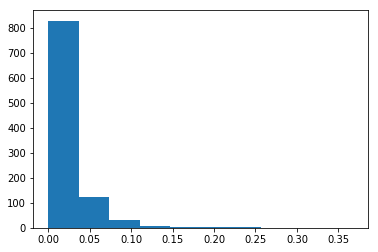

Discriminator on real samples: tensor(0.0474, device='cuda:0')
tensor(0.0474, device='cuda:0')


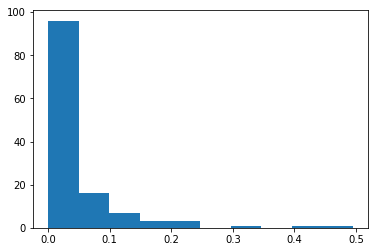

In [44]:
"""Compare discriminator on real and fake samples"""

num_samples_to_generate = 1000

model.eval()

with torch.no_grad():
    # seed = 42
    # rng = np.random.RandomState(seed)
    # Sample latent vectors
    z = sample_latent_space(num_samples_to_generate)
    z = torch.from_numpy(z).float()
    z = z.to(device)
    x = model.generator(z)
    y = model.discriminator(x)
    print("Discriminator on fake samples:", torch.mean(y))
    plt.hist(y.data.cpu().numpy())
    plt.show()

    x = next(iter(train_loader))[0]
    x = x.to(device)
    y = model.discriminator(x)
    print("Discriminator on real samples:", torch.mean(y))
    print(torch.mean(y))
    plt.hist(y.data.cpu().numpy())
    plt.show()


(64, 64)


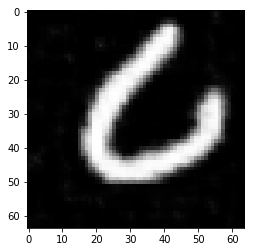

(64, 64)


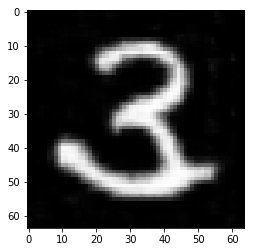

(64, 64)


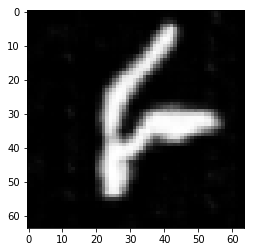

(64, 64)


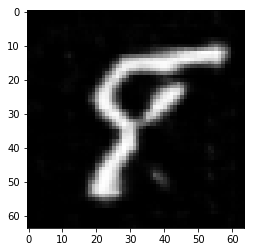

(64, 64)


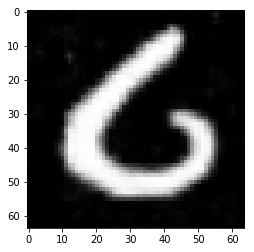

(64, 64)


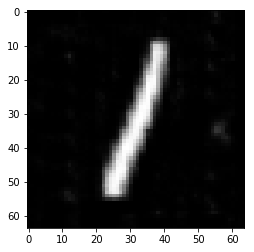

(64, 64)


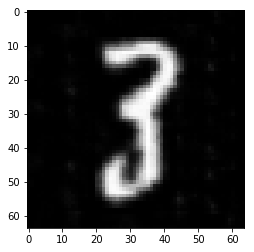

(64, 64)


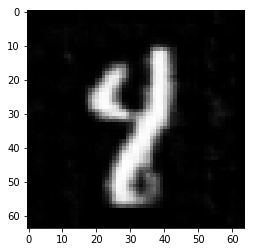

In [45]:
"""Sample some images"""

model.eval()

with torch.no_grad():
    num_samples_to_generate = 8
    z = sample_latent_space(num_samples_to_generate)
    z = torch.from_numpy(z).float()
    z = z.to(device)
    samples = model.generator(z)
    samples = samples.cpu()

for i in range(samples.size(0)):
    sample = samples[i, ...]
    sample = sample.view(image_size_y, image_size_x)
    sample = sample.data.numpy()
    print(sample.shape)
    plt.figure()
    plt.imshow(sample, cmap="gray")
    plt.show()

(64, 64) -1.0 0.99215686


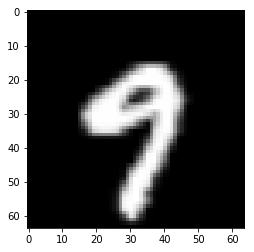

(64, 64) -1.0 0.99215686


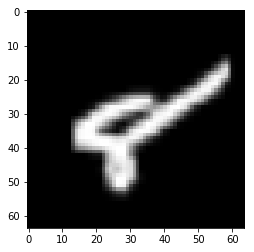

(64, 64) -1.0 1.0


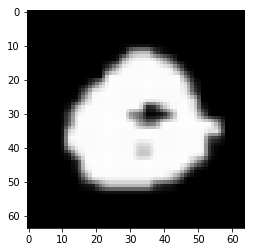

(64, 64) -1.0 0.9843137


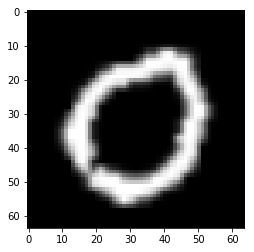

(64, 64) -1.0 0.9843137


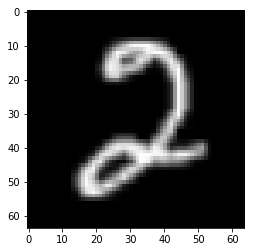

(64, 64) -1.0 0.9764706


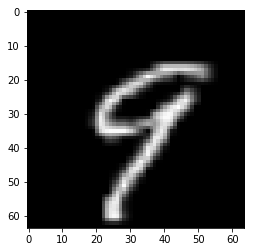

(64, 64) -1.0 0.9843137


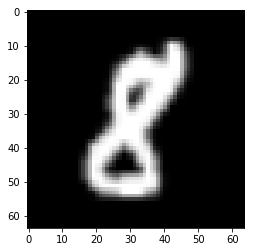

(64, 64) -1.0 0.9843137


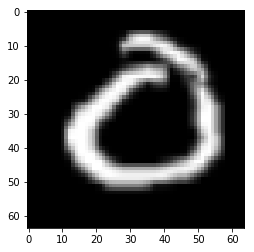

In [30]:
"""Show real images"""

num_images = 8
samples = next(iter(train_loader))[0][:num_images]
for i in range(samples.size(0)):
    sample = samples[i, ...]
    sample = sample.view(image_size_y, image_size_x)
    sample = sample.data.numpy()
    print(sample.shape, np.min(sample), np.max(sample))
    plt.figure()
    plt.imshow(sample, cmap="gray")
    plt.show()

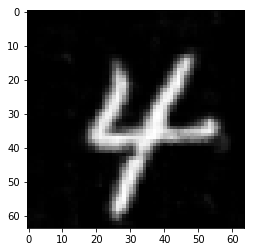

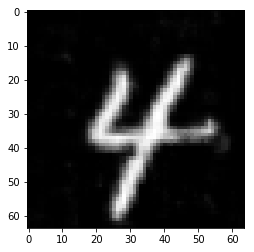

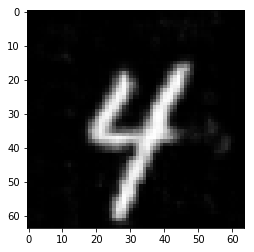

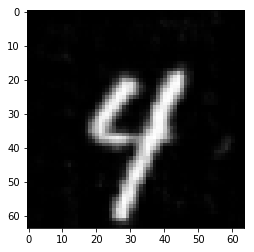

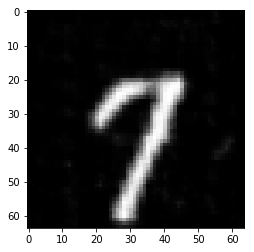

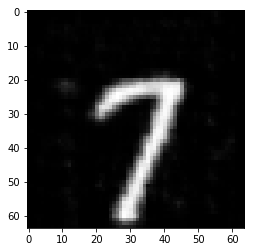

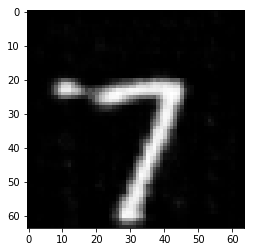

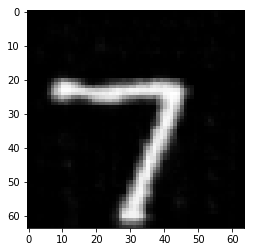

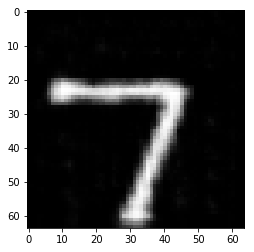

In [46]:
"""Interpolate between images"""

model.eval()

# seed = 46
# rng = np.random.RandomState(seed)
z = sample_latent_space_torch(2)
w = Variable(torch.linspace(0, 1, 10))
z = z[0, ...] + (z[1, ...] - z[0, ...]) * w[:, None]
z = z.to(device)
x = model.generator(z)

x = x.data.cpu().numpy().reshape((-1, image_size_y, image_size_x))
x1 = x[0, ...]
x2 = x[-1, ...]

plt.figure()
plt.imshow(x1, cmap="gray")
plt.close()
for i in range(x.shape[0]):
    plt.figure()
    plt.imshow(x[i, ...], cmap="gray")
plt.close()
plt.figure()
plt.imshow(x2, cmap="gray")
plt.close()
plt.show()
